<div class="alert alert-block alert-info">
    <h1>Natural Language Processing</h1>
    Assignment 05
    <h3>General Information:</h3>
    <p>Please do not add or delete any cells. Answers belong into the corresponding cells (below the question). If a function is given (either as a signature or a full function), you should not change the name, arguments or return value of the function.<br><br> If you encounter empty cells underneath the answer that can not be edited, please ignore them, they are for testing purposes.<br><br>When editing an assignment there can be the case that there are variables in the kernel. To make sure your assignment works, please restart the kernel and run all cells before submitting (e.g. via <i>Kernel -> Restart & Run All</i>).</p>
    <p>Code cells where you are supposed to give your answer often include the line  ```raise NotImplementedError```. This makes it easier to automatically grade answers. If you edit the cell please outcomment or delete this line.</p>
    <h3>Submission:</h3>
    <p>Please submit your notebook via the web interface (in the main view -> Assignments -> Submit). The assignments are due on <b>Monday at 13:00</b>.</p>
    <h3>Group Work:</h3>
    <p>You are allowed to work in groups of up to three people. Please enter the UID (your username here) of each member of the group into the next cell. We apply plagiarism checking, so do not submit solutions from other people except your team members. If an assignment has a copied solution, the task will be graded with 0 points for all people with the same solution.</p>
    <h3>Questions about the Assignment:</h3>
    <p>If you have questions about the assignment please post them in the LEA forum before the deadline. Don't wait until the last day to post questions.</p>
    
</div>

In [41]:
'''
Group Work:
Enter the username of each team member into the variables. 
If you work alone please leave the other variables empty.
'''
member1 = 'mfarra2s'
member2 = 'rhusai2s'
member3 = ''

# Neural Language Model

In this task we want to implement the neural language model given in chapter 7 of the book (p. 16) using PyTorch.

<img src="Neural_Language_Model_files/img/model.png">

© Tim Metzler, Hochschule Bonn-Rhein-Sieg

## Helper Functions

You are given some helper functions to make this assignment easier.

First a tokenizer that turns strings into lists of token ids.

In [42]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from typing import List

def tokenizer_from_strings(strings: List[str], vocab_size: int = None) -> Tokenizer:
    """
    Create and train a WordLevel Tokenizer for tokenizing text from the given strings.

    Args:
        strings (List[str]): A list of strings containing the text data for training.
        vocab_size (int, optional): The maximum vocabulary size to limit the number of tokens
                                    in the tokenizer. If None, the vocabulary size is determined automatically.
                                    Defaults to None.

    Returns:
        Tokenizer: A trained WordLevel Tokenizer capable of tokenizing text data.    
    """    
    tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))

    # We can also pass a vocab_size to the trainer to only keep the most frequent words
    # Special tokens are tokens that we want to use but are not part of the text we train on
    trainer = WordLevelTrainer(
        special_tokens=["[UNK]", "<s>", "</s>"], 
    )
    if vocab_size is not None:
        trainer.vocab_size = vocab_size
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.train_from_iterator(strings, trainer=trainer)
    return tokenizer


In [43]:
# Example texts for our tokenizer. This can be a list of one our more documents
my_text = [
    "<s> I like NLP. </s>",
    "It is very interesting",
    "But it is also hard"
]

tokenizer = tokenizer_from_strings(my_text)

# Let us look at our trained vocabulary
print("The vocabulary")
print(tokenizer.get_vocab())

# Size of the vocabulary
print("\nThe size of the vocabulary")
print(tokenizer.get_vocab_size())

# Now lets turn a sentence into a list of token indices
encoded_input = tokenizer.encode("NLP is hard")

# This is how it splits it into tokens
print("\nThe tokens from our input string")
print(encoded_input.tokens)
# This is how we get the ids
print("\nThe ids for the tokens")
print(encoded_input.ids)

# Let us look what happens if we put in unknown words
encoded_input = tokenizer.encode("NLP is a tough subject")
print("\nThe tokens from our input string. Notice how everything unknown is represented as [UNK]")
print(encoded_input.tokens)
print("\nThe ids for the tokens")
print(encoded_input.ids)

# Finally we can also turn back ids into strings
tokenizer.decode([6, 13, 8])

The vocabulary
{'is': 4, '</': 8, 'also': 13, 's': 5, '</s>': 2, 'But': 9, 'NLP': 12, 'It': 11, 'very': 18, 'it': 16, 'like': 17, 'I': 10, 'interesting': 15, '[UNK]': 0, '<s>': 1, '<': 7, '.': 6, 'hard': 14, '>': 3}

The size of the vocabulary
19

The tokens from our input string
['NLP', 'is', 'hard']

The ids for the tokens
[12, 4, 14]

The tokens from our input string. Notice how everything unknown is represented as [UNK]
['NLP', 'is', '[UNK]', '[UNK]', '[UNK]']

The ids for the tokens
[12, 4, 0, 0, 0]


'. also </'

## Neural Language Model A)
### One Hot Encoder

First we create a one-hot encoder that produces tensors. We will use the built-in function `torch.nn.functional.one_hot` to create our embeddings.

First look at the example in the following cell.

Then complete the class `OneHotEncoder` below. You need to implement the method `encode`, which encodes a single index into a one-hot embedding and the method `encode_sequence`, which will take a list of indices and should return a list of one-hot embeddings.

In [44]:
from torch import tensor
from torch.nn.functional import one_hot

index = 5
vocab_size = 20

my_one_hot_embedding = one_hot(
    tensor(index),
    num_classes=vocab_size
).float()

print(my_one_hot_embedding)          # The embedding
print(my_one_hot_embedding.shape)    # The size of the embedding
print(my_one_hot_embedding.argmax()) # The index of the 1

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
torch.Size([20])
tensor(5)


In [45]:
from torch.nn.functional import one_hot
from torch import tensor, float32
from typing import List

class OneHotEncoder:
    
    def __init__(self, vocab_size: int):
        """
        OneHotEncoder class for converting token IDs to one-hot encoded tensors.

        Args:
            vocab_size (int): The size of the vocabulary, i.e., the number of unique tokens.
        """
        self.vocab_size = vocab_size
        
    def encode(self, token_id: int) -> tensor:
        """
        Encode a single token ID as a one-hot encoded tensor.

        Args:
            token_id (int): The token ID to be encoded.

        Returns:
            tensor: The one-hot encoded tensor representing the input token ID.
        """
        return one_hot(tensor(token_id), num_classes= self.vocab_size).float()
    
    def encode_sequence(self, token_ids: List[int]) -> List[tensor]:
        """
        Encode a sequence of token IDs as a list of one-hot encoded tensors.

        Args:
            token_ids (List[int]): A list of token IDs to be encoded.

        Returns:
            List[tensor]: A list of one-hot encoded tensors representing the input token IDs.
        """
        embedings = []
        for ind in token_ids:
            embedings.append(one_hot(tensor(ind), num_classes= self.vocab_size).float())
            
        return embedings
            

In [46]:
# This is for you to test if your implementation is working

vocabulary_size = 50

encoder = OneHotEncoder(vocabulary_size)

# Test with a single index
embedding = encoder.encode(5)

assert embedding.shape[0] == vocabulary_size, "All embeddings should have the size of the vocabulary"
assert embedding.argmax() == 5, "The single one should be at index 5"

# Test with a list of indices
indices = [5, 3, 7]
embeddings = encoder.encode_sequence(indices)

assert len(embeddings) == 3, "We put in three indices so we want three embeddings"
assert isinstance(embeddings, list), "We want to return a list"

for idx, embedding in zip(indices, embeddings):
    assert embedding.shape[0] == vocabulary_size, "All embeddings should have the size of the vocabulary"
    assert embedding.argmax() == idx, "The single one should be at index 5" 



## Neural Language Model B)
### The model

Complete the model class below.

**Hint: To get from three tensors of size $d$ to a tensor of size $3d$ we need to concatenate. See the next cell for an example**

In [47]:
import torch

# Create our encoder and encode three indices
encoder = OneHotEncoder(12)
indices = [5, 3, 7]
embedding1, embedding2, embedding3 = encoder.encode_sequence(indices)

# Concatenate them into a single embedding of size 3*vocab_size
concatenated_embeddings = torch.concatenate((embedding1, embedding2, embedding3))

print(concatenated_embeddings.shape) # This is three times our vocabulary size
print(concatenated_embeddings)

torch.Size([36])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [48]:
import torch.nn as nn
from torch import TensorType

class NeuralLanguageModel(nn.Module):
    """
    A neural language model that predicts a word from two input words
    """
    
    def __init__(self, vocab_size: int, embedding_size: int, hidden_size: int):
        """
        Initializes the NeuralLanguageModel.

        Args:
            vocab_size (int): The size of the vocabulary.
            embedding_size (int): The size of word embeddings.
            hidden_size (int): The size of the hidden layer
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        # Create your layers here. All layers are linear
        # We want an embedding layer
        self.embedding = nn.Linear(self.vocab_size, self.embedding_size)
        # Then a hidden layer
        self.hidden = nn.Linear(3*self.embedding_size, self.hidden_size)
        # Then an output layer
        self.output = nn.Linear(self.hidden_size,self.vocab_size)
        # Then we define our activation functions and the softmax
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax()
        
        
    def forward(
        self, 
        word1: TensorType, 
        word2: TensorType, 
        word3: TensorType, 
        inference: bool=False
    ) -> TensorType:
        """
        Forward pass of the neural language model.

        Args:
            word1 (torch.TensorType): Tensor representing the first word (one-hot).
            word2 (torch.TensorType): Tensor representing the second word (one-hot).
            word3 (torch.TensorType): Tensor representing the third word (one-hot).
            inference (bool, optional): Flag representing if we are doing inference or not.
                                        This is needed since during training PyTorch does not work well with
                                        the softmax. 

        Returns:
            torch.TensorType: Output tensor representing the probability distribution over the vocabulary.
        """
        # This will be our output
        x1 = self.embedding(word1)
        x2 = self.embedding(word2)
        x3 = self.embedding(word3)
        y = torch.cat((x1, x2, x3), dim=-1)
        
#         x = torch.concatenate((word1, word2, word3))
#         print(word1.shape)
#         print(x.shape)
#         y = self.embedding(x)
        y = self.hidden(y)
        y = self.activation(y)
        y = self.output(y)       
        
        # The loss we will use later does not play well with softmax. 
        # So we only apply it for inferencing
        if inference:
            y = self.softmax(y)        
        return y

In [49]:
# This is to test your implementation

# First create the model
vocab_size = 50
model = NeuralLanguageModel(
    vocab_size=vocab_size,
    embedding_size=16,
    hidden_size=10
)

# Next create some inputs for our model
encoder = OneHotEncoder(vocab_size)

word1, word2, word3 = encoder.encode_sequence([3, 7, 2])

# Now we feed it to our model
output = model(word1, word2, word3)

print(output)
assert output.shape[0] == vocab_size, "Our output should have the size of the vocabulary"

# Next we do the same for inference (we check if the softmax is applied then)
output = model(word1, word2, word3, inference=True)
print(output)

assert abs(output.sum().item() - 1) < 10e-6, "The outputs should sum up to 1"


tensor([ 0.0740,  0.0229,  0.1719,  0.0541, -0.0604,  0.1465, -0.3477, -0.1297,
         0.2599, -0.2497,  0.2973, -0.1395, -0.1857,  0.2469,  0.0942, -0.1472,
         0.1477, -0.2054, -0.2845, -0.3283,  0.0500, -0.2007,  0.1455, -0.2583,
         0.0714,  0.0671, -0.2971, -0.1860,  0.2659,  0.0637,  0.1151,  0.1627,
        -0.2914, -0.0198, -0.3259, -0.2389, -0.2950, -0.0595,  0.0064,  0.2538,
         0.1873,  0.0719,  0.2822, -0.2693, -0.2765,  0.1144, -0.2607, -0.0305,
         0.0829, -0.2906], grad_fn=<ViewBackward0>)
tensor([0.0219, 0.0209, 0.0242, 0.0215, 0.0192, 0.0236, 0.0144, 0.0179, 0.0264,
        0.0159, 0.0274, 0.0177, 0.0169, 0.0261, 0.0224, 0.0176, 0.0236, 0.0166,
        0.0153, 0.0147, 0.0214, 0.0167, 0.0236, 0.0157, 0.0219, 0.0218, 0.0151,
        0.0169, 0.0266, 0.0217, 0.0229, 0.0240, 0.0152, 0.0200, 0.0147, 0.0160,
        0.0152, 0.0192, 0.0205, 0.0263, 0.0246, 0.0219, 0.0270, 0.0156, 0.0155,
        0.0229, 0.0157, 0.0198, 0.0221, 0.0152], grad_fn=<SoftmaxBac

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


## The Dataset

The dataset class was already implemented for you. Look at it and understand what it does.

In [50]:
from torch.utils.data import Dataset, DataLoader
from typing import List, Any, Tuple

def sliding_window(sequence: List[Any], window_size: int) -> List[Any]:
    """
    Generate a sliding window over a sequence (list).

    Args:
        sequence (list): The input sequence.
        window_size (int): The size of the sliding window.

    Yields:
        list: A window of elements from the input sequence.
    """
    for i in range(len(sequence) - window_size + 1):
        yield sequence[i:i + window_size]
        

class NGramTextDataset(Dataset):
    """
    A PyTorch Dataset class for generating trigram-based text datasets.

    Args:
        sentences (List[str]): A list of input sentences.
        vocab_size (int, optional): The size of the vocabulary to use for tokenization.
                                    Defaults to None.

    Methods:
        __len__(self) -> int: Returns the total number of examples in the dataset.

        __getitem__(self, index: int) -> Tuple[List[int], int]:
            Returns a tuple containing the input trigram and its corresponding label for the specified index.

    Example:
        sentences = ["This is a sample sentence.", "Another example sentence."]
        dataset = TrigramTextDataset(sentences, vocab_size=10000)
        dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    """
    
    def __init__(self, sentences: List[str], vocab_size: int=None):
        """
        Initializes the TrigramTextDataset with input sentences and vocabulary size.

        Args:
            sentences (List[str]): A list of input sentences.
            vocab_size (int, optional): The size of the vocabulary to use for tokenization.
                                        Defaults to None.
        """
        # First augment the sentences with a start and end symbol
        # We add three of each since we look at four grams
        sentences = [
            '<s> <s> <s>' + sentence + ' </s> </s> </s>'
            for sentence in sentences
        ]
        # Next we train our tokenizer
        self.tokenizer = tokenizer_from_strings(sentences, vocab_size)
        self.encoder = OneHotEncoder(self.tokenizer.get_vocab_size())
        
        # Prepare our examples
        self.inputs = []
        self.labels = []
        
        for sentence in sentences:
            # Go over each trigram of the encoded sentence
            for trigram in sliding_window(self.tokenizer.encode(sentence).ids, 4):
                # Take the first two tokens as input
                self.inputs.append(trigram[:-1])
                # Take the last token as the label
                self.labels.append(trigram[-1])
                
    def __len__(self) -> int:
        """
        Returns the total number of examples in the dataset.

        Returns:
            int: The number of examples in the dataset.
        """
        return len(self.labels)
    
    def __getitem__(self, index: int) -> Tuple[List[torch.tensor], torch.tensor]:
        """
        Returns a tuple containing the input trigram and its corresponding label for the specified index.

        Args:
            index (int): The index of the example to retrieve.

        Returns:
            Tuple[List[int], int]: A tuple containing the input trigram (a list of integers) and
            its corresponding label (an integer).
        """
        return self.encoder.encode_sequence(self.inputs[index]), self.encoder.encode(self.labels[index])

In [51]:
# Open our training data
# This file has one sentence per line
with open('/srv/shares/NLP/datasets/marvel/spider_man_homecoming.txt', 'r') as f:
    text = f.read()
    
# Create the dataset
dataset = NGramTextDataset(text.split("\n"))

# Look at one example
inputs, label = dataset[4]

print(inputs)
print(label)

# We can also turn this back into strings using the tokenizer
word1, word2, word3 = inputs

# Turn the one-hot vectors back to indices
indices = [
    word1.argmax().item(),
    word2.argmax().item(),
    word3.argmax().item()
]

label_index = label.argmax().item()

# Turn these indices back to strings
dataset.tokenizer.decode(indices), dataset.tokenizer.decode([label_index])

[tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.])]
tensor([0., 0., 0.,  ..., 0., 0., 0.])


('Adrian Toomes and', 'his')

In [52]:
print(word1)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


## Neural Language Model C)
### The training loop and optimizer

Please implement the training loop below. 
This method receives a model, an optimizer, a loss function and a dataloader.

In [53]:
from typing import List
from torch.optim import Optimizer
from torch.nn.modules.loss import _Loss
import numpy as np

def train_one_epoch(
    model: nn.Module, 
    optimizer: Optimizer, 
    loss_fn: _Loss, 
    dataloader: DataLoader) -> float:
    """
    Trains a neural network model for one epoch using the specified data.

    Parameters:
        model (nn.Module): The neural network model to be trained.
        optimizer (Optimizer): The optimizer used for updating model weights.
        loss_fn (_Loss): The loss function used to compute the training loss.
        dataloader (DataLoader): The data loader providing batches of training data.

    Returns:
        float: The mean training loss for the entire epoch.
    """
    batch_losses = []
    
    for batch_id, data in enumerate(dataloader):
#         print("b",batch_id)
#         print("d",data)

        inputs, labels = data
        word1, word2, word3 = inputs
        print(word1)
#         print("w",word1[0])
#         outputs = model(word1[0], word2[0], word3[0])

        # We need to zero our gradients for every batch!
        optimizer.zero_grad()

        # Calculate loss
        loss = loss_fn(outputs, labels[0])

        # Calculate gradient from loss
        loss.backward()

        # Update weights
        optimizer.step()

        # Record the loss
        batch_losses.append(loss.item())
        
        return np.mean(batch_losses)


## Neural Language Model D)
### Creating the optimizer, loss, model and dataloader

Use a batch size of 256 for your data loader.

Initialize your model with an embedding size of 8 and a hidden size of 12.

Use AdamW as your optimizer with a learning rate of 0.01.

Use the CrossEntropyLoss as the loss function

In [54]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

vocab_size = dataset.tokenizer.get_vocab_size()

model = NeuralLanguageModel(vocab_size= vocab_size, embedding_size=8, hidden_size=12)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.01)

## Neural Language Model E)
### Train the model

Train the model for at least 10 epochs (this should take about 3 minutes).

**Hint: If you want a progress bar for your loops you can use the following code:**



In [55]:
from tqdm.notebook import tqdm_notebook

epoch_losses = []

for i in tqdm_notebook(range(10), desc="Processing"):

   
    
#     epoch_losses.append( train_one_epoch( model, 
#                     optimizer, 
#                     loss_fn, 
#                     dataloader))

    batch_losses = []

    for batch_id, data in enumerate(dataloader):
#         print("b",batch_id)
#         print("d",data)

        inputs, labels = data
        word1, word2, word3 = inputs
#         print(word1)
#         print("w",word1[0])
        outputs = model(word1, word2, word3)
        
        # We need to zero our gradients for every batch!
        optimizer.zero_grad()

        # Calculate loss
        loss = loss_fn(outputs, labels)

        # Calculate gradient from loss
        loss.backward()

        # Update weights
        optimizer.step()

        # Record the loss
        batch_losses.append(loss.item())

    epoch_losses.append(np.mean(batch_losses))

epoch_losses

Processing:   0%|          | 0/10 [00:00<?, ?it/s]

[5.05574184773015,
 4.002994163363588,
 3.6176302877126956,
 3.3918839435951385,
 3.2453005570991365,
 3.1354138862852956,
 3.047662863544389,
 2.9745425605306437,
 2.9141877655889474,
 2.8609562714894614]

## Neural Language Model F)
### Plot the losses

Create a plot with the batch losses.
Your x axis is the epoch, your y axis is the loss.

Don't forget labels, a title and a grid

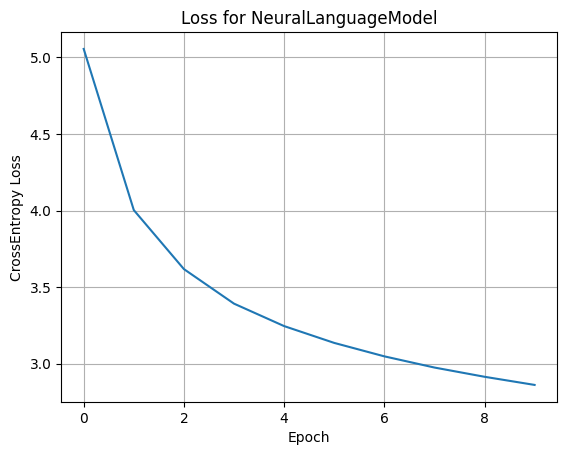

In [56]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)

plt.grid()
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.title("Loss for NeuralLanguageModel")

plt.show()

In [57]:
# Here we can do inference
sentence = "<s> <s> I'm a little station on the ground"

tokenized = dataset.tokenizer.encode(sentence)
token_ids = tokenized.ids

onehots = dataset.encoder.encode_sequence(token_ids)[-3:]

predicted_index = model(*onehots, inference=True).argmax().item()

dataset.tokenizer.decode([predicted_index])

def generate_random_sentence(model, dataset, input_sequence):
    sentence_end = False
    while not sentence_end:
        tokenized = dataset.tokenizer.encode(input_sequence)
        token_ids = tokenized.ids

        onehots = dataset.encoder.encode_sequence(token_ids)[-3:]
        
        probabilities = model(*onehots, inference=True).detach().numpy()
        
        
        
        next_index = np.random.choice(model.vocab_size, p=probabilities)
        
        # We specified <s> and </s> as special tokens. To have them be part of the output 
        # we need to set the flag skip_special_tokens=False
        next_word = dataset.tokenizer.decode([next_index], skip_special_tokens=False)
        sentence_end = next_word == "</s>"
        input_sequence += f" {next_word}"
    return input_sequence

generate_random_sentence(model, dataset, "<s> <s> <s> No")

'<s> <s> <s> No , no , no , no . </s>'